| Column Name            | Description                                                                                     | Type     | Comments |
|------------------------|-------------------------------------------------------------------------------------------------|----------| -------- |
| Date                   | The date of the observation. (Date)                                                            | Date     | Only dates so we need to combine with time which creating a new variable |
| Time                   | The time of the observation. (Time)                                                            | Time     | Use |
| Global_active_power    | The total active power consumed by the household (kilowatts). (Numeric)                         | Numeric  | Target variable as we can predict the power consumption of the household |
| Global_reactive_power  | The total reactive power consumed by the household (kilowatts). (Numeric)                       | Numeric  | Not used because Reactive power uses for inductive devices such as motors and transformers |
| Voltage                | The voltage at which the electricity is delivered to the household (volts). (Numeric)          | Numeric  | Not use |
| Global_intensity       | The average current intensity delivered to the household (amps). (Numeric)                     | Numeric  | Not use |
| Sub_metering_1         | The active power consumed by the kitchen (kilowatts). (Numeric)                                 | Numeric  | Use |
| Sub_metering_2         | The active power consumed by the laundry room (kilowatts). (Numeric)                            | Numeric  | Use |
| Sub_metering_3         | The active power consumed by the electric water heater and air conditioner (kilowatts). (Numeric)| Numeric  | Use |


## Problem Statement
Predict the total active power consumption (`Global_active_power`) of the household based on the power consumed by the kitchen (`Sub_metering_1`), laundry room (`Sub_metering_2`), and the electric water heater and air conditioner (`Sub_metering_3`).

This problem statement focuses on using machine learning to understand the relationship between the power consumed by different parts of the household and the total power consumption. This could help in optimizing energy usage and planning for future power needs.

## Time Consumption(%) and Work Approach
1. (40%) Data Preprocessing: 
    - Rename columns, datatypes
    - Remove/Fill missing values
    - Create new timeframe variables
    - Remove unnecessary variables
    - Transform variables e.g. log transformation, scaling
    <br></br>
1. (30%) Exploratory Data Analysis: 
    - Visualize the data with line plots, histograms, and boxplots
<br></br>
1. (20%) Modeling:
    1. Train/Validation/Test Split
    1. Machine Learning Modeling:
        - Polynomical Regression
        - XGBoost
        - Random Forest
        - CatBoost
    1. Hyperparameter Tuning with GridSearchCV
        <br></br>
1. (10%) Evaluation:
    - RMSE
    - Visualization
    - Error


## Import Libraries and Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
# df_original = pd.read_csv('household_power_consumption.csv')
df_original = pd.read_csv('/kaggle/input/240000-household-electricity-consumption-records/household_power_consumption.csv')
df = df_original.copy()
df.head()

,index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0,1/1/07,0:00:00,2.58,0.136,241.97,10.6,0,0,0.0
1,1,1/1/07,0:01:00,2.552,0.1,241.75,10.4,0,0,0.0
2,2,1/1/07,0:02:00,2.55,0.1,241.64,10.4,0,0,0.0
3,3,1/1/07,0:03:00,2.55,0.1,241.71,10.4,0,0,0.0
4,4,1/1/07,0:04:00,2.554,0.1,241.98,10.4,0,0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260640 entries, 0 to 260639
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  260640 non-null  int64  
 1   Date                   260640 non-null  object 
 2   Time                   260640 non-null  object 
 3   Global_active_power    260640 non-null  object 
 4   Global_reactive_power  260640 non-null  object 
 5   Voltage                260640 non-null  object 
 6   Global_intensity       260640 non-null  object 
 7   Sub_metering_1         260640 non-null  object 
 8   Sub_metering_2         260640 non-null  object 
 9   Sub_metering_3         256869 non-null  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 19.9+ MB


In [4]:
df.shape

(260640, 10)

## Data Preprocessing

### Convert data types

In [5]:
df['Date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df[['Global_active_power', 'Date_time', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')
df['Sub_metering_3'] = pd.to_numeric(df['Sub_metering_3'], errors='coerce')

### Handling Missing Values and transforming data

In [6]:
from sklearn.preprocessing import RobustScaler

# Fill na with values forward
print(f'Missing Value found: {df.isna().sum()}')
print('*'*100)
df = df.fillna(method='ffill')

# Transform data with RobustScaler
rs = RobustScaler()
num_cols = ['Sub_metering_1', 'Sub_metering_2','Sub_metering_3']
df[num_cols] = rs.fit_transform(df[num_cols])


Missing Value found: Global_active_power    3771
Date_time                 0
Sub_metering_1         3771
Sub_metering_2         3771
Sub_metering_3         3771
dtype: int64
****************************************************************************************************


| Method | Action | Equivalent |
| --- | --- | --- |
| pad / ffill | Fill values forward | `fillna(method='ffill')` |
| bfill / backfill | Fill values backward | `fillna(method='bfill')` |

With time series data, using `pad/ffill` is extremely common so that the 'last known value' is available at every time point.

More details can be found in the [Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html).

In [7]:
num_cols = ['Sub_metering_1', 'Sub_metering_2','Sub_metering_3']
df[num_cols] = rs.fit_transform(df[num_cols])

## Exploratory Data Analysis

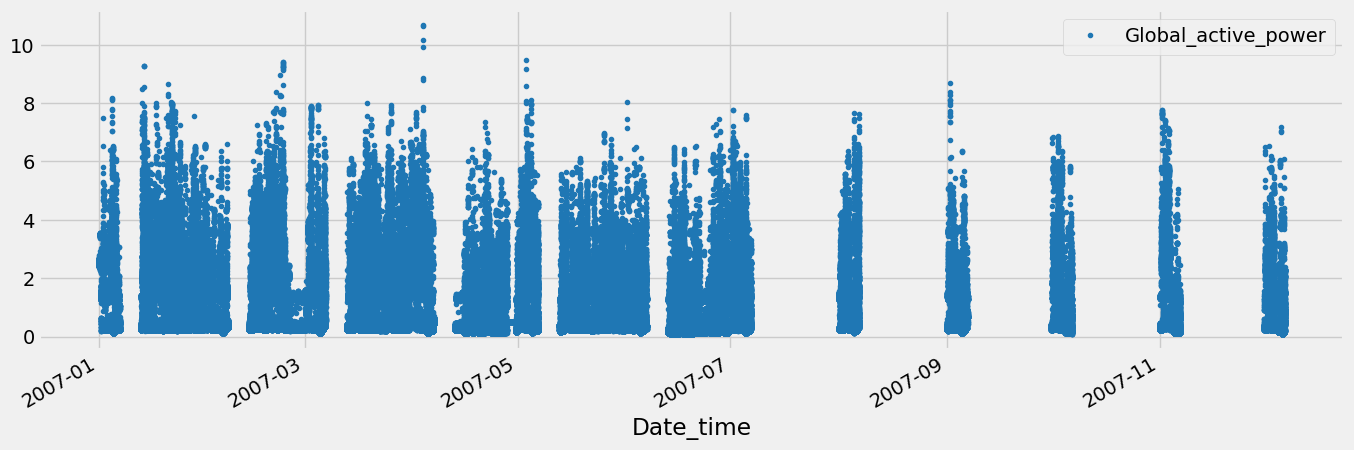

In [8]:
df.plot(x='Date_time', y='Global_active_power',style='.',
        figsize=(15, 5),
        color=color_pal[0])
plt.show()

In [9]:
# The data has periodic gaps, so we check for missing values
df.isna().sum()

Global_active_power    0
Date_time              0
Sub_metering_1         0
Sub_metering_2         0
Sub_metering_3         0
dtype: int64

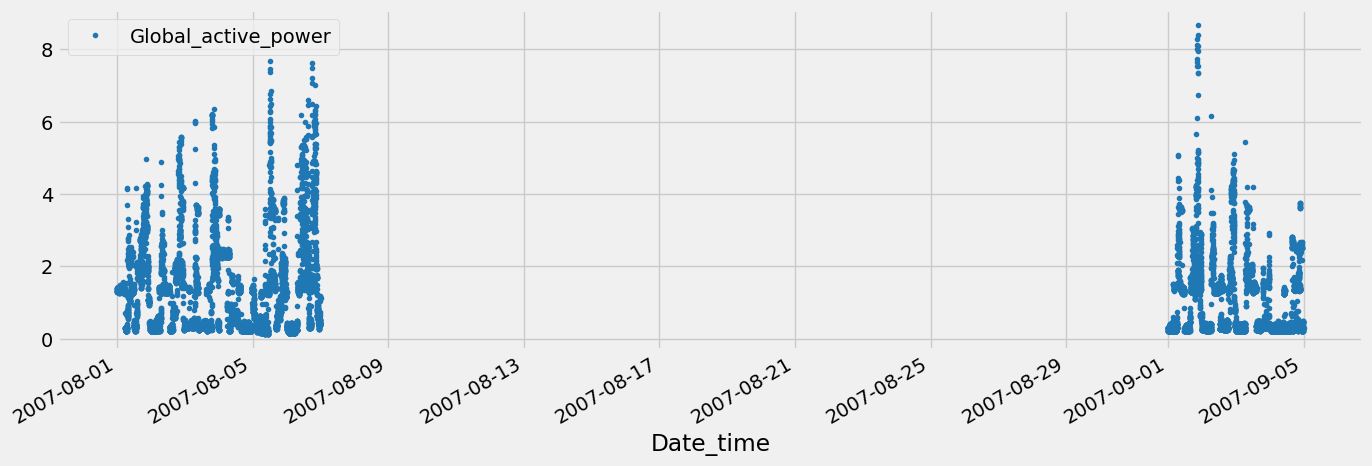

In [10]:
# Investigate the gap with no values. In this example, I draw a sample in August.
no_val = df.loc[(df['Date_time'] >= '2007-08-01') & (df['Date_time'] < '2007-09-05')]

no_val.plot(x='Date_time', y='Global_active_power',style='.',
        figsize=(15, 5),
        color=color_pal[0])
plt.show()

In [11]:
# Assign Date_time to index so it will be easier when using plots
df = df.set_index(df['Date_time'])
df.index = pd.to_datetime(df.index)

In [12]:
# Function Creating Features for time series analysis
def time_series_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month

    return df

df_ts = time_series_features(df)

# day 0 = Monday and replace 1 instead of 0 for more legible.
df_ts['day'] = df_ts['day']+1

In the `dayofweek` attribute of a pandas DatetimeIndex, the definitions of the days are as follows:

- 0: Monday
- 1: Tuesday
- 2: Wednesday
- 3: Thursday
- 4: Friday
- 5: Saturday
- 6: Sunday

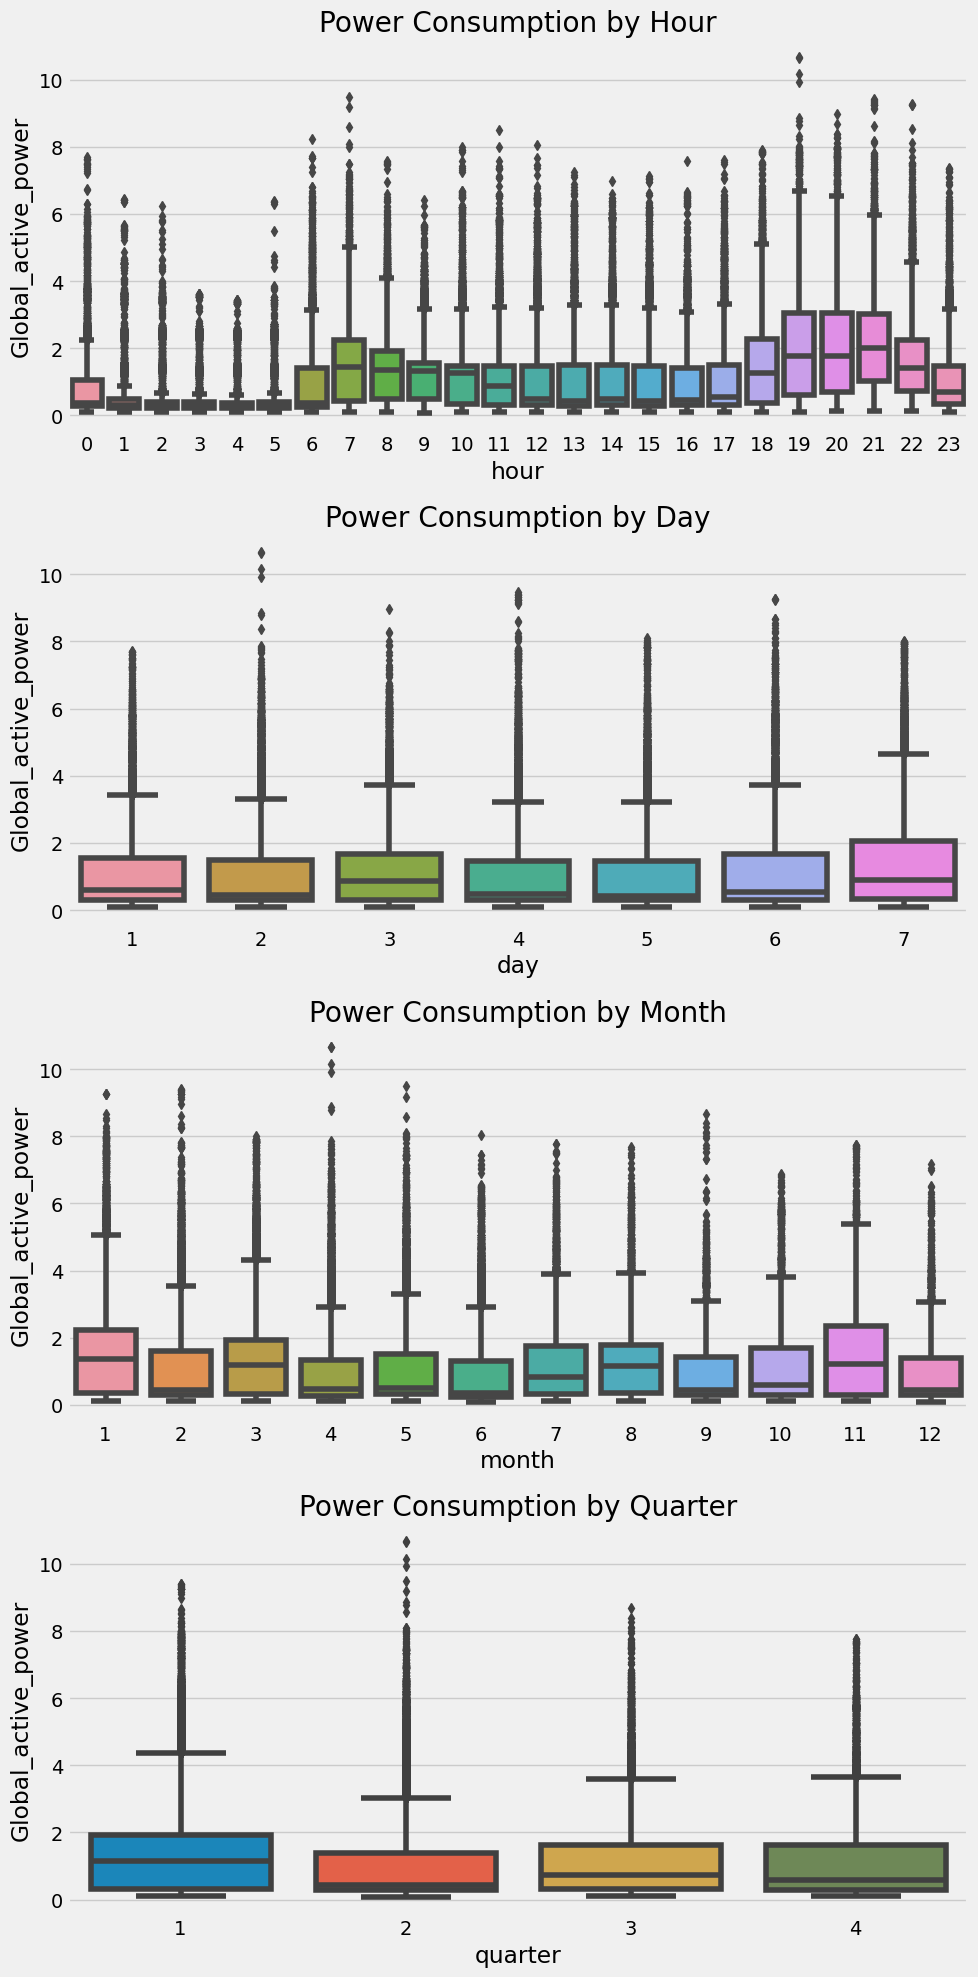

In [13]:
# Visualize the power consumption in various timeframes.

fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Consumption by Hour
sns.boxplot(data=df_ts, x='hour', y='Global_active_power', ax=axs[0])
axs[0].set_title('Power Consumption by Hour')

# Consumption by Day
sns.boxplot(data=df_ts, x='day', y='Global_active_power', ax=axs[1])
axs[1].set_title('Power Consumption by Day')

# Consumption by Month
sns.boxplot(data=df_ts, x='month', y='Global_active_power', ax=axs[2])
axs[2].set_title('Power Consumption by Month')

# Consumption by Quarter
sns.boxplot(data=df_ts, x='quarter', y='Global_active_power', ax=axs[3])
axs[3].set_title('Power Consumption by Quarter')

plt.tight_layout()
plt.show()

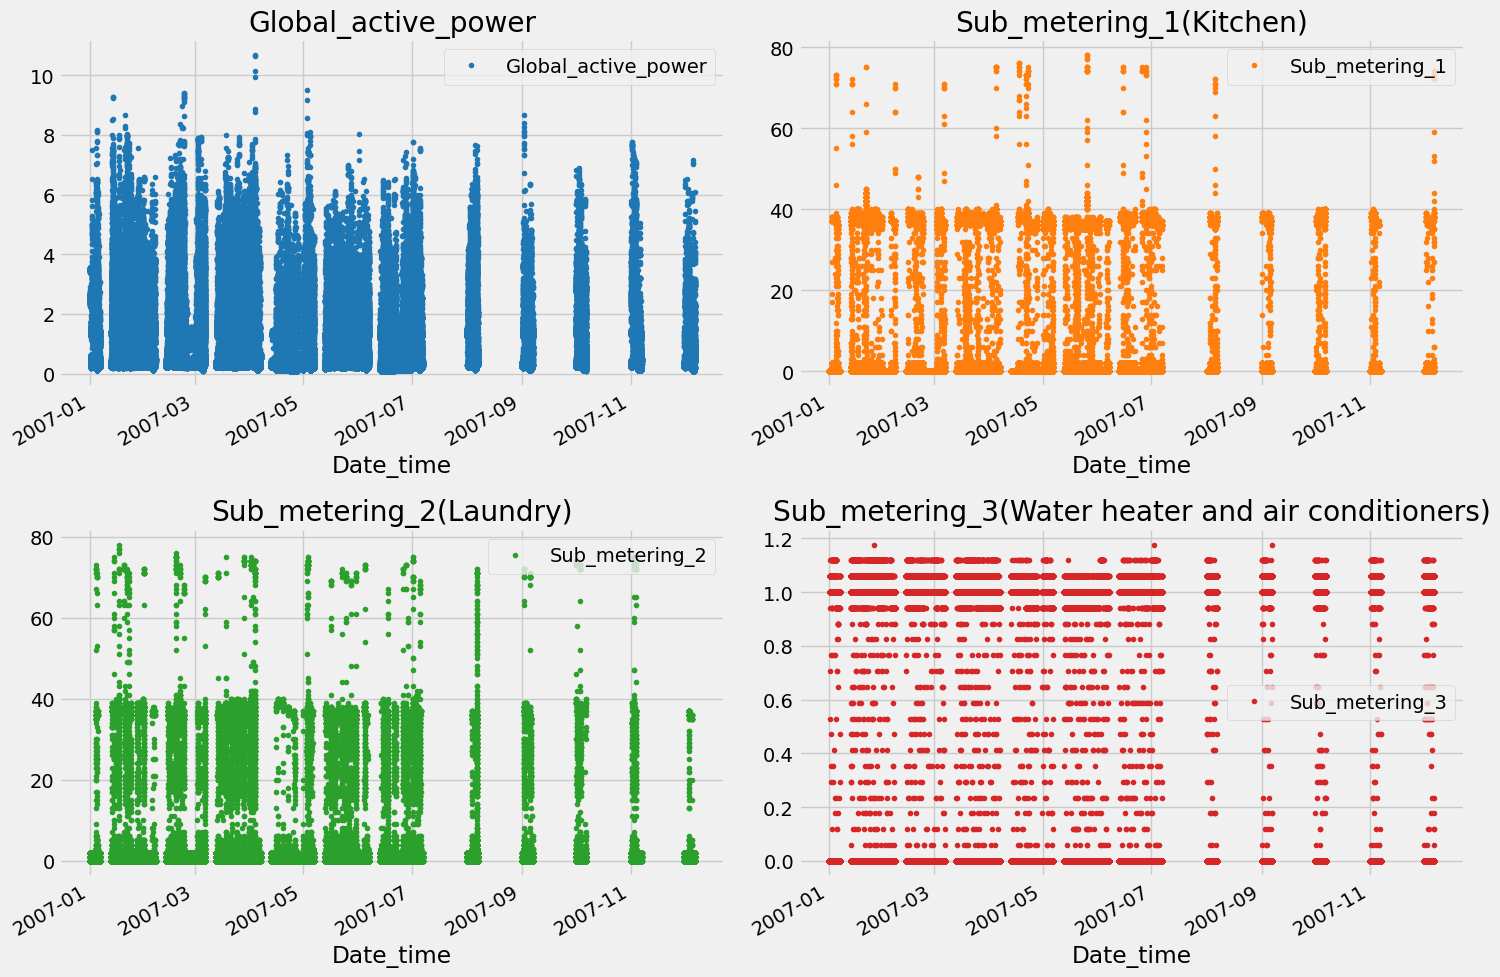

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

df.plot(x='Date_time', y='Global_active_power',style='.',color=color_pal[0], ax=axes[0,0], title='Global_active_power')
df.plot(x='Date_time', y='Sub_metering_1',style='.',color=color_pal[1], ax=axes[0,1], title='Sub_metering_1(Kitchen)')
df.plot(x='Date_time', y='Sub_metering_2',style='.',color=color_pal[2], ax=axes[1,0], title='Sub_metering_2(Laundry)')
df.plot(x='Date_time', y='Sub_metering_3',style='.',color=color_pal[3], ax=axes[1,1], title='Sub_metering_3(Water heater and air conditioners)')

plt.tight_layout()
plt.show()

## Modeling

### Split by time period

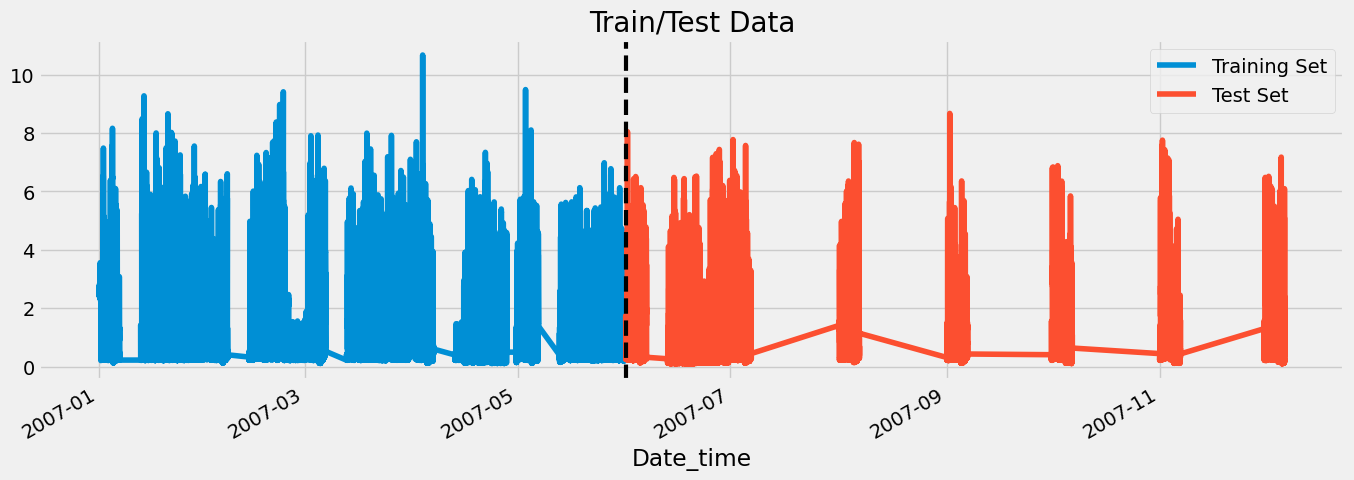

In [15]:
# Split the data as of June because 1) there are many gaps from August to December so it would not help to see the performance of the models properly; 2) we can visualize the result in quarterly namely Q3 and Q4.
date_split = pd.to_datetime('2007-06-01')

train = df.loc[df.index <= date_split]
test = df.loc[df.index > date_split]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(x='Date_time', y='Global_active_power', ax=ax, label='Training Set', title='Train/Test Data')
test.plot(x='Date_time', y='Global_active_power', ax=ax, label='Test Set')
ax.axvline(date_split, color='black', ls='--', linewidth=3)
ax.legend(['Training Set', 'Test Set'])
plt.show()

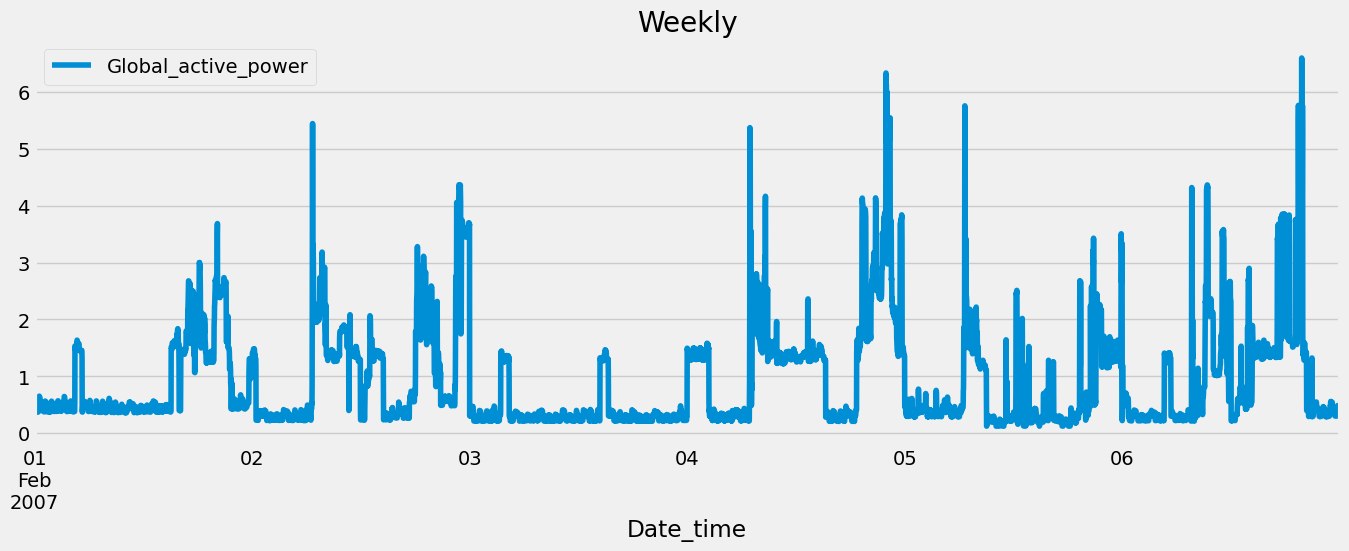

In [16]:
# Observed data in a weekly timeframe which drew the sample in February
df.loc[(df.index >= '2007-02-01') & (df.index < '2007-02-08')].plot(x='Date_time', y='Global_active_power', figsize=(15, 5), title='Weekly')
plt.show()

### Split data into train, validation, and test sets

In [17]:
from sklearn.model_selection import train_test_split

train = time_series_features(train)
test = time_series_features(test)
features = ['Sub_metering_1', 'Sub_metering_2','Sub_metering_3']
target = 'Global_active_power'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


### Train Models

#### Polynomial Regression

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

poly_reg = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_reg.fit(X_train, y_train)

y_pred_poly_val = poly_reg.predict(X_val)
rmse_poly_val = mean_squared_error(y_val, y_pred_poly_val, squared=False)
print(f'Validation RMSE for Polynomial Regression: {rmse_poly_val}')

y_pred_poly = poly_reg.predict(X_test)
rmse_poly = mean_squared_error(y_test, y_pred_poly, squared=False)
print(f'Test RMSE for Polynomial Regression: {rmse_poly}')

Validation RMSE for Polynomial Regression: 0.6801153967765324
Test RMSE for Polynomial Regression: 0.611966299412667


#### XGBoost

In [19]:
import xgboost as xgb

xg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=3000,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.003,
                       random_state=42)

xg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=90, verbose=500)

y_pred_xgb = xg.predict(X_test)

rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f'Test RMSE: {rmse}')

[0]	validation_0-rmse:1.39024
[500]	validation_0-rmse:0.74017
[1000]	validation_0-rmse:0.68241
[1500]	validation_0-rmse:0.67682
[2000]	validation_0-rmse:0.67606
[2500]	validation_0-rmse:0.67597
[2999]	validation_0-rmse:0.67595
Test RMSE: 0.6084413865554301


### Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf_val = rf.predict(X_val)
rmse_rf_val = mean_squared_error(y_val, y_pred_rf_val, squared=False)
print(f'Validation RMSE for Random Forest: {rmse_rf_val}')

y_pred_rf = rf.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print(f'Test RMSE for Random Forest: {rmse_rf}')

Validation RMSE for Random Forest: 0.6782835447103531
Test RMSE for Random Forest: 0.6151196034736062


### CatBoost

In [21]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(verbose=False)
cat.fit(X_train, y_train, eval_set=(X_val, y_val))

y_pred_cat_val = cat.predict(X_val)
rmse_cat_val = mean_squared_error(y_val, y_pred_cat_val, squared=False)
print(f'Validation RMSE for CatBoost: {rmse_cat_val}')

y_pred_cat = cat.predict(X_test)
rmse_cat = mean_squared_error(y_test, y_pred_cat, squared=False)
print(f'Test RMSE for CatBoost: {rmse_cat}')

Validation RMSE for CatBoost: 0.6753517564096183
Test RMSE for CatBoost: 0.610332792071764


In [22]:
from sklearn.metrics import mean_absolute_error

metrics_dict = {'Model': [], 'RMSE': [], 'MSE': [], 'MAE': []}
models = [poly_reg, xg, rf, cat] 
model_names = ['Polynomial Regression', 'XGBoost', 'Random Forest', 'CatBoost']

for model, name in zip(models, model_names):
    y_pred = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    metrics_dict['Model'].append(name)
    metrics_dict['RMSE'].append(rmse)
    metrics_dict['MSE'].append(mse)
    metrics_dict['MAE'].append(mae)

metrics_df = pd.DataFrame(metrics_dict)
metrics_df.style.format({'RMSE': '{:.3f}', 'MSE': '{:.3f}', 'MAE': '{:.3f}'}).highlight_min(color='lightblue', subset=['RMSE','MSE','MAE'])

,Model,RMSE,MSE,MAE
0,Polynomial Regression,0.612,0.375,0.454
1,XGBoost,0.608,0.370,0.448
2,Random Forest,0.615,0.378,0.450
3,CatBoost,0.610,0.373,0.449


### Hyperparameter Tuning

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [5, 7, 9],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),
                           param_grid=param_grid,
                           cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)  # use all available cores if you have a multi-core processor

grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(best_params)

# Re-train the model using the best parameters
xg = xgb.XGBRegressor(**best_params)
xg.fit(X_train, y_train)

{'colsample_bytree': 1, 'max_depth': 5, 'subsample': 1}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Evaluation

### Feature Importance

Feature: Sub_metering_1, Score: 0.17602
Feature: Sub_metering_2, Score: 0.15408
Feature: Sub_metering_3, Score: 0.66990


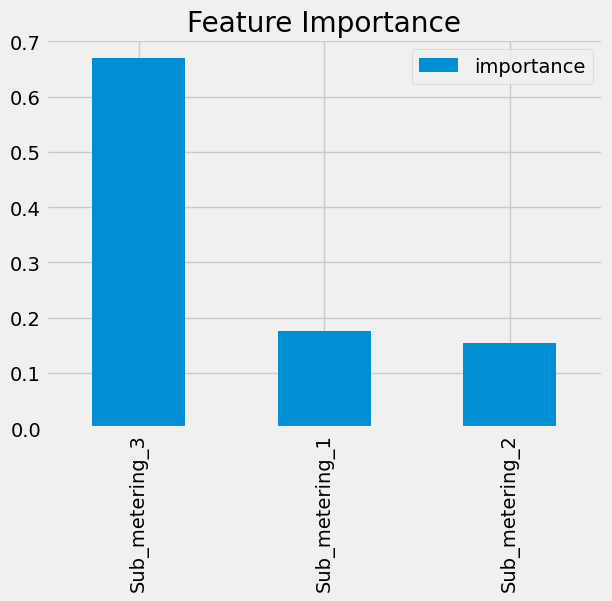

In [24]:
# Result
importance = xg.feature_importances_
for i, j in enumerate(importance):
    print(f'Feature: {xg.feature_names_in_[i]}, Score: {j:.5f}')

# Plot
fi = pd.DataFrame(data=xg.feature_importances_,
             index=xg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance', ascending=False).plot(kind='bar', title='Feature Importance')
plt.show()

### RMSE and Error

In [25]:
# RMSE Score
test['Prediction'] = xg.predict(X_test)
score = mean_squared_error(test['Global_active_power'], test['Prediction'], squared=False)
print(f'RMSE Score on Test set: {score:0.3f}')

RMSE Score on Test set: 0.612


In [26]:
# Error
test['Error'] = np.abs(test[target] - test['Prediction'])
test['Date'] = test.index.date
test.groupby(['Date'])['Error'].mean().sort_values(ascending=False).head(10)

Date
2007-11-03    1.136503
2007-11-02    1.116964
2007-08-04    0.689616
2007-06-05    0.640886
2007-10-02    0.639730
2007-11-01    0.603811
2007-07-02    0.601537
2007-10-03    0.594549
2007-10-01    0.535650
2007-12-02    0.517885
Name: Error, dtype: float64

### Visualize the predictions in various time periods

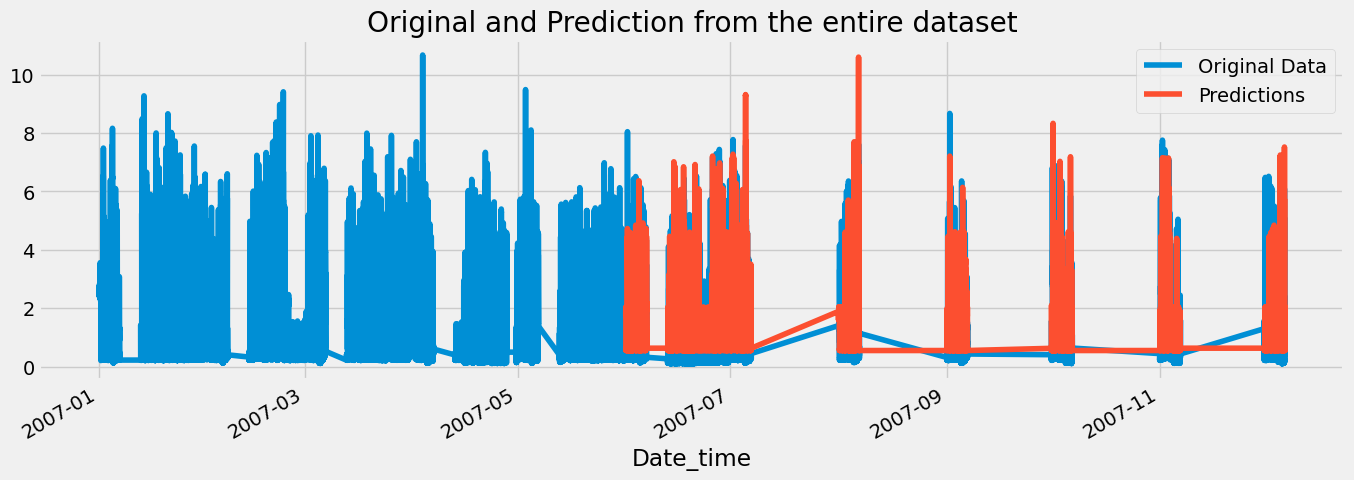

In [27]:
df = df.merge(test['Prediction'], how='left', left_index=True, right_index=True)
ax = df[['Global_active_power']].plot(figsize=(15, 5))
df['Prediction'].plot(ax=ax, style='')
plt.legend(['Original Data', 'Predictions'])
ax.set_title('Original and Prediction from the entire dataset')
plt.show()

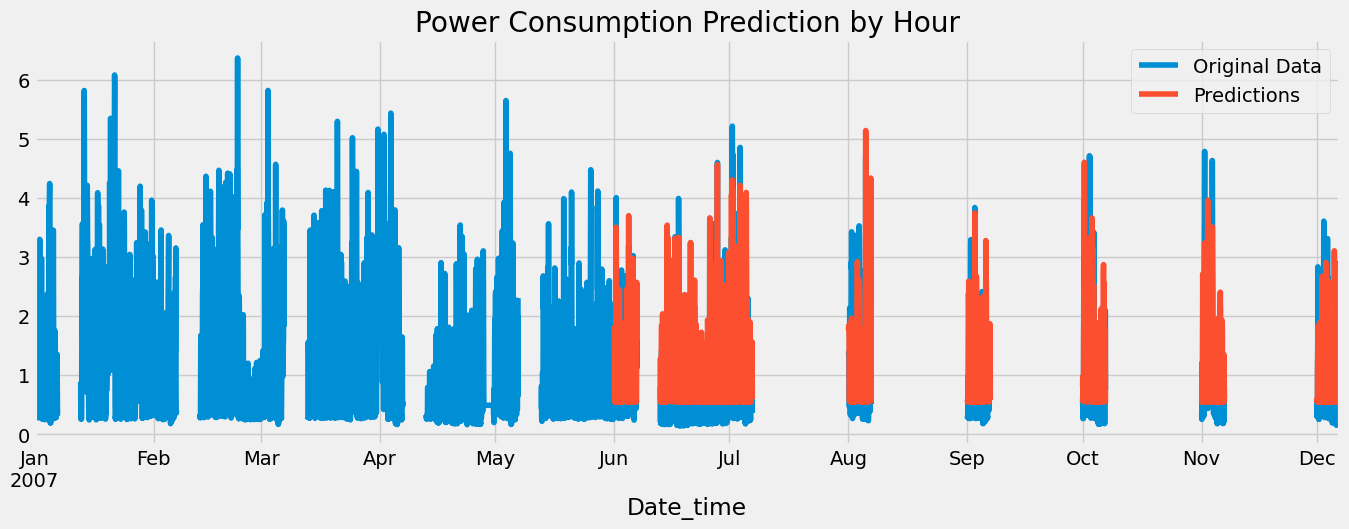

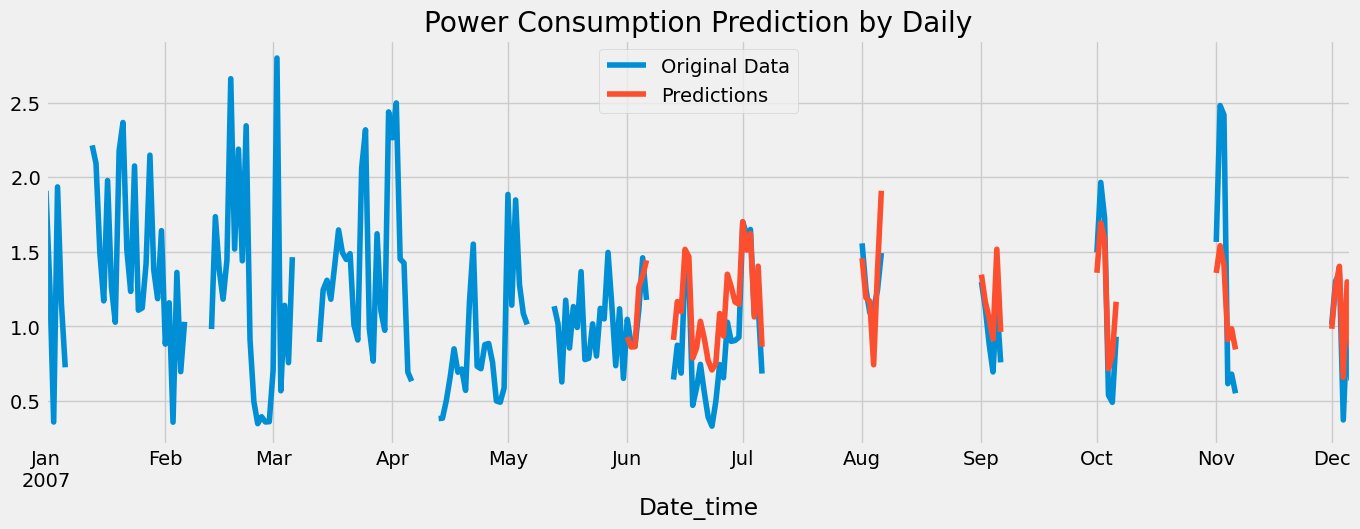

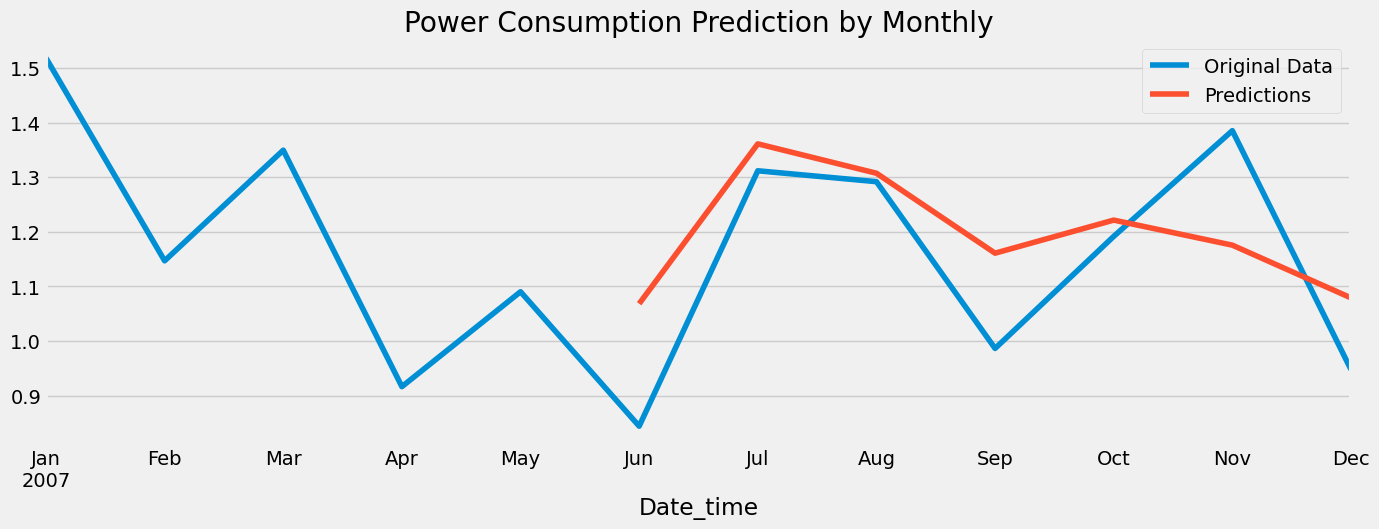

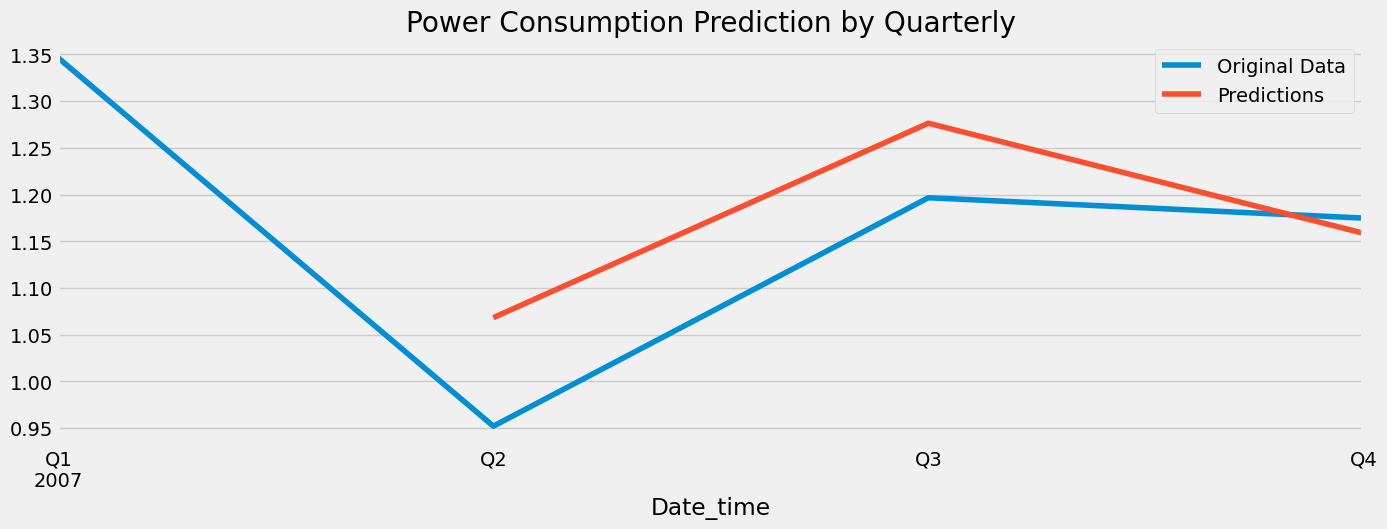

In [28]:
# Resample
df_hour = df.resample('H').mean()
df_daily = df.resample('D').mean()
df_monthly = df.resample('M').mean()
df_quarterly = df.resample('Q').mean()

dfs = [(df_hour, 'Hour'),(df_daily, 'Daily'), (df_monthly, 'Monthly'), (df_quarterly, 'Quarterly')]

for df, title in dfs:
    ax = df[['Global_active_power']].plot(figsize=(15, 5))
    df['Prediction'].plot(ax=ax, style='')
    plt.legend(['Original Data', 'Predictions'])
    ax.set_title(f'Power Consumption Prediction by {title}')
    plt.show()

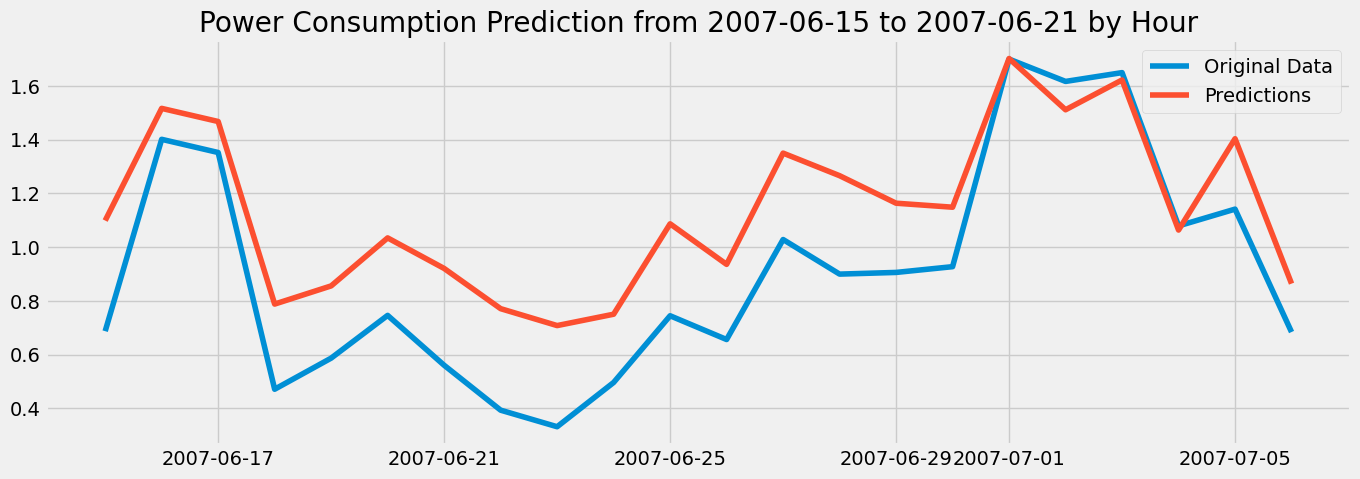

In [29]:
# Select mid of June to observe the prediction in a smaller scale as this period contained the complete data.
df_june = df_daily[(df_daily.index >= '2007-06-15') & (df_daily.index < '2007-07-15')]

plt.figure(figsize=(15, 5))
plt.plot(df_june.index, df_june['Global_active_power'], label='Original Data')
plt.plot(df_june.index, df_june['Prediction'], label='Predictions')
plt.title('Power Consumption Prediction from 2007-06-15 to 2007-06-21 by Hour')
plt.legend()
plt.show()

Resampling options:
- `'H'` for hourly frequency
- `'D'` for daily frequency
- `'B'` for business day frequency
- `'W'` for weekly frequency
- `'M'` for month end frequency
- `'Q'` for quarter end frequency
- `'A'` for year end frequency

## Conclusion

### Model and Technical Conclusion
- XGBoost has the best performance with RMSE of 0.608, MSE of 0.370, and MAE of 0.448 based on the train set. With the hyperparameters (colsample_bytree of 0.7, max_depth of 5, and subsample of 1), the RMSE on the test set is 0.611.
- The power consumed by the electric water heater and air conditioner (`Sub_metering_3`) is the most important feature in the model. This suggests that it has a significant impact to the total power consumption of the household.
- The error shows that the model is not able to predict accurately which may cause by special events, holidays, or other factors that are not included in the dataset. Which may need to collect more data to improve the model.


### Stakeholders
- Homeowners
- Utility and energy companies
- Energy regulators and/or agencies

### Business Recommendations
- Help in planning for future power needs, manage supply and demand, and avoiding overloads or power outages.
- Help households reduce an electricity bill and optimize the electricity usage.

### Future Works and/or Improvements
1. Data Collection

    This conclusion and recommendations are based on the results of the model and the available data. Collecting more data and exploring more features (factors) could improve an accuracy of the prediction.
1. Expert Consultation

    Discussing and obtaining feedbacks from domain knowledge experts to improve the model and the recommendations, construct valid questions, answer business needs.
1. Model Re-evaluation and Improvement

    Monitoring and re-evaluating the model regularly to ensure that it is still relevant and accurate. In addition, applying more techniques in data preprocessing, different models, and neural network models.
1. Model Application

    Applying the model to other countries and/or regions to evaluate if the power consumption behavior is similar or different.
